# OPTIMISERS AND CALLBACKS

In [102]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import random
from random import choice
from string import ascii_uppercase
from time import sleep

from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array

import os
from os import listdir
from os.path import isfile, join
import re

import matplotlib.pyplot as plt
%matplotlib inline

### CLASSIFICATION

In [103]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [104]:
model = Sequential()

In [105]:
#Adding Convolution layer
img_width, img_height = 64,64
model.add(Conv2D(32,(3,3),input_shape=(img_width,img_height,3),activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [106]:
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [107]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

In [108]:
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [109]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 64)         

In [110]:
#Generating image data

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale=1./255)

In [111]:
#Fitting image to the CNN
#Defining data directory
train_data_dir = 'D:/DATASCIENCE/TshirtShirt/training'
validation_data_dir = 'D:/DATASCIENCE/TshirtShirt/validation'

nb_train_samples =1397
nb_validation_samples = 40
epochs = 20
batch_size = 30

training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size=(64,64),
                                                batch_size = batch_size,
                                                class_mode = 'binary')


test_set = test_datagen.flow_from_directory(validation_data_dir,
                                           target_size=(64,64),
                                           batch_size=batch_size,
                                           class_mode='binary')

Found 1397 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


#### EARLY STOPPING

In [112]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor ='val_loss',
                  min_delta = 0,
                  patience=5,
                  verbose=1) #To keeps the best weight

#### REDUCE LR ON PLATEAU

In [113]:
from keras.callbacks import ReduceLROnPlateau

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=3,
                          verbose = 1,
                         min_delta=0)

#### CHECK POINT

In [114]:
from keras.callbacks import ModelCheckpoint

mcp = ModelCheckpoint('fr_4_optimiser.h5',
                     monitor='val_loss',
                     model='min',
                     save_best_only=True,
                     verbose=1)

#### CALLBACKS

In [115]:

callbacks = [es,rlrop,mcp]

In [116]:
#Training and Evaluating the model

def model_fit(optimiser,epochs):
    
    #Compiling the CNN
    model.compile(optimizer = optimiser,loss = 'binary_crossentropy',metrics = ['accuracy'])

    history = model.fit( 
        training_set, 
        steps_per_epoch=nb_train_samples // batch_size, 
        epochs=epochs, 
        validation_data=test_set, 
        callbacks=callbacks,
        validation_steps=nb_validation_samples // batch_size)
    
    results = model.evaluate(test_set, batch_size=batch_size)
    print("test loss, test acc:", results)
    
    # Loss Curves
    plt.figure(figsize=[5,5])
    plt.plot(history.history['loss'],'r',linewidth=1.0)
    plt.plot(history.history['val_loss'],'b',linewidth=1.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
    plt.xlabel('Epochs ',fontsize=12)
    plt.ylabel('Loss',fontsize=12)
    plt.title('Loss Curves',fontsize=12)
    
    # Accuracy Curves
    plt.figure(figsize=[5,5])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
    plt.xlabel('Epochs ',fontsize=12)
    plt.ylabel('Accuracy',fontsize=12)
    plt.title('Accuracy Curves',fontsize=12)
    
    

    history4 = history
    accuracy = history4.history['accuracy']
    val_accuracy = history4.history['val_accuracy']
    loss = history4.history['loss']
    val_loss = history4.history['val_loss']
    epochs = range(len(accuracy))

    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    return model

#### FUNCTION TO PREDICT TEST DATA

In [117]:
class_labels = test_set.class_indices
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500, cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, "predicted - "+pred,(20,60), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
    cv2.putText(expanded_image, "true - "+true_label,(20,120), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
    cv2.imshow(name, expanded_image)
    
def getRandomImage(path, img_width, img_height):
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path,x)),os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" +image_name
    return load_img(final_path,target_size = (img_width,img_height)), final_path, path_class

def predictTestData(model_name):
    
    #dimension of image
    img_width, img_height = 64,64

    files=[]
    predictions = []
    true_labels = []

    #predicting images
    for i in range(0,10):
        path = validation_data_dir+'/'
        img, final_path, true_label = getRandomImage(path, img_width, img_height)
        files.append(final_path)
        true_labels.append(true_label)
        x = img_to_array(img)
        x = x*1./255
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model_name.predict_classes(images,batch_size=10)
        predictions.append(classes)

    for i in range(0,len(files)):
        image = cv2.imread((files[i]))
        true_pred = true_labels[i]
        draw_test("Prediction ", class_labels[predictions[i][0][0]],image, true_pred)
        cv2.waitKey(0)

    cv2.destroyAllWindows()

### OPTIMISERS

#### SGD

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5355
Epoch 00001: val_loss improved from inf to 0.67282, saving model to fr_4_optimiser.h5
46/46 [==============================] - 13s 278ms/step - loss: 0.6894 - accuracy: 0.5355 - val_loss: 0.6728 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.6313
Epoch 00002: val_loss improved from 0.67282 to 0.61381, saving model to fr_4_optimiser.h5
46/46 [==============================] - 14s 312ms/step - loss: 0.6509 - accuracy: 0.6313 - val_loss: 0.6138 - val_accuracy: 0.6333 - lr: 0.0100
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.7118
Epoch 00003: val_loss improved from 0.61381 to 0.57846, saving model to fr_4_optimiser.h5
46/46 [==============================] - 16s 351ms/step - loss: 0.5793 - accuracy: 0.7118 - val_loss: 0.5785 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 4/20
46/46 

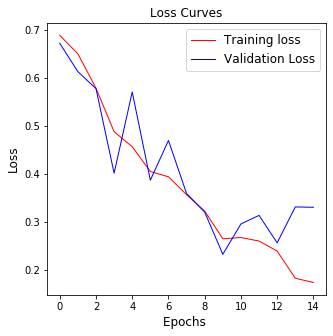

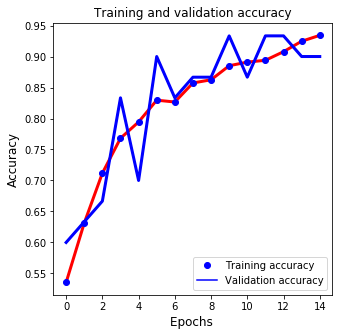

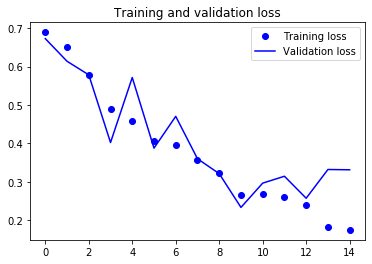

In [118]:
from keras.optimizers import SGD

sgd = SGD(lr=0.01,momentum=0.9)

sgd_model = model_fit(sgd,epochs)

In [119]:
#Predicting on test data

predictTestData(sgd_model)

#### RMSprop

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 28.3790 - accuracy: 0.5955
Epoch 00001: val_loss did not improve from 0.23316
46/46 [==============================] - 13s 291ms/step - loss: 28.3790 - accuracy: 0.5955 - val_loss: 0.5319 - val_accuracy: 0.7667 - lr: 0.0100
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.7103
Epoch 00002: val_loss did not improve from 0.23316
46/46 [==============================] - 13s 290ms/step - loss: 0.5911 - accuracy: 0.7103 - val_loss: 0.7045 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 1.1143 - accuracy: 0.6606
Epoch 00003: val_loss did not improve from 0.23316
46/46 [==============================] - 12s 257ms/step - loss: 1.1143 - accuracy: 0.6606 - val_loss: 0.6306 - val_accuracy: 0.7000 - lr: 0.0100
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.7220
Epoch 00004: val_loss did not impr

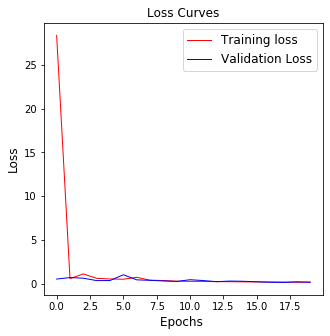

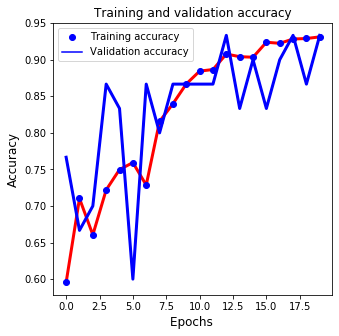

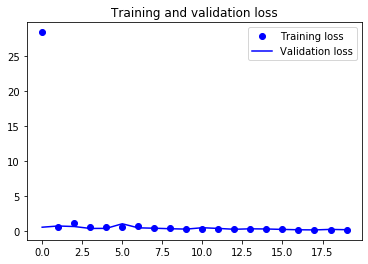

In [120]:
from keras.optimizers import RMSprop

rms = RMSprop(lr=0.01)

rms_model = model_fit(rms,epochs)

In [121]:
#Predicting on test data

predictTestData(rms_model)

#### Adam Optimizer

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8347
Epoch 00001: val_loss did not improve from 0.14560
46/46 [==============================] - 13s 278ms/step - loss: 0.4091 - accuracy: 0.8347 - val_loss: 0.4676 - val_accuracy: 0.8333 - lr: 0.0100
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8669
Epoch 00002: val_loss did not improve from 0.14560
46/46 [==============================] - 13s 272ms/step - loss: 0.3263 - accuracy: 0.8669 - val_loss: 0.4178 - val_accuracy: 0.8000 - lr: 0.0100
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.8632
Epoch 00003: val_loss did not improve from 0.14560
46/46 [==============================] - 13s 274ms/step - loss: 0.2938 - accuracy: 0.8632 - val_loss: 0.2170 - val_accuracy: 0.9000 - lr: 0.0100
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.8917
Epoch 00004: val_loss did not improv

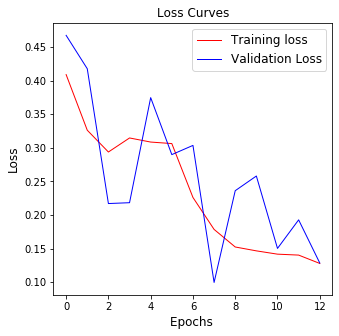

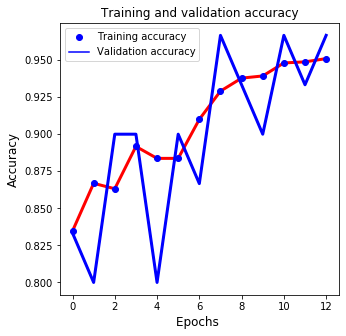

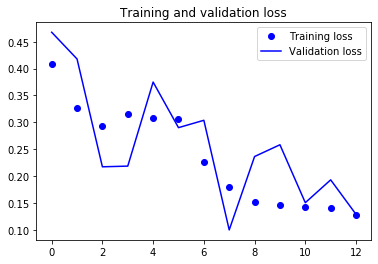

In [122]:
from keras.optimizers import Adam

adam = Adam(lr=0.01)
adam_model = model_fit(adam,epochs)

In [123]:
#Predicting on test data

predictTestData(adam_model)

#### NADAM OPTIMISER

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 66.0079 - accuracy: 0.5245
Epoch 00001: val_loss did not improve from 0.09952
46/46 [==============================] - 14s 311ms/step - loss: 66.0079 - accuracy: 0.5245 - val_loss: 0.6923 - val_accuracy: 0.5333 - lr: 0.1000
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5026
Epoch 00002: val_loss did not improve from 0.09952
46/46 [==============================] - 13s 272ms/step - loss: 0.6962 - accuracy: 0.5026 - val_loss: 0.6944 - val_accuracy: 0.5000 - lr: 0.1000
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.5143
Epoch 00003: val_loss did not improve from 0.09952
46/46 [==============================] - 12s 271ms/step - loss: 0.6940 - accuracy: 0.5143 - val_loss: 0.6979 - val_accuracy: 0.4333 - lr: 0.1000
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5004
Epoch 00004: val_loss did not impr

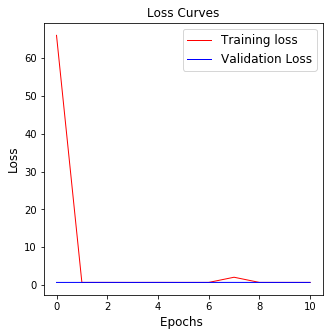

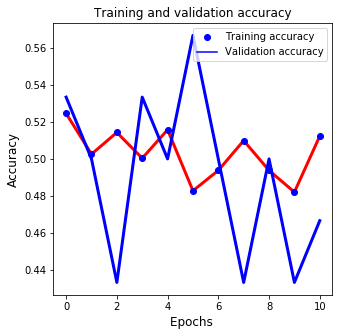

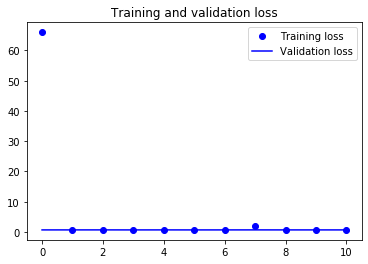

In [124]:
from keras.optimizers import Nadam

nadam = Nadam(lr=0.1)
nadam_model = model_fit(nadam,epochs)

### SAVING MODEL

In [125]:
#Saving the model
nadam_model.save('optimiser_and_callback_nadam.h5')

In [126]:
#Saving the model
adam_model.save('optimiser_and_callback_adam.h5')

In [127]:
#Saving the model
sgd_model.save('optimiser_and_callback_sgd.h5')

In [128]:
#Saving the model
rms_model.save('optimiser_and_callback_rmsprop.h5')

In [129]:
#loading the model for testing
from keras.models import load_model 
classifier = load_model('optimiser_and_callback_rmsprop.h5')

In [130]:
from keras.preprocessing import image
import numpy as np

#Loading image from drive
test_image =image.load_img('D:/DATASCIENCE/TshirtShirt/manual_test/17.jpg',target_size =(64,64))

#Converting image to array
test_image =image.img_to_array(test_image)
test_image =np.expand_dims(test_image, axis =0)

#Predicting image
result = classifier.predict(test_image)
if result[0][0] >= 0.5:
    prediction = 'tshirt'
else:
    prediction = 'shirt'
print(prediction)

shirt


### CONCLUSION

In this assignment, I've tried to classify two category images. I downloaded images from Flipkart for two different categories by using a web scraping script. Then, saved all images in a directory with two labels as a t-shirt and shirt.Then imported the required libraries of Keras and created a model with a convolutional layers, a dense layer, and also added dropout to avoid overfitting/underfitting, then I've used various callbacks and optimisers to check model performance using learning rate and momentum for SGD, then compiled the model with test and train data, After testing multiple images manually I found that the model is predicting 8 out of 10 images correctly.